<h1 align="center">Creating Trackers Using Stone Soup</h1>
<h3 align="center">Multi Target Detection Simulator Example</h3>

Before beginning to construct your tracker it is a good idea to refer to the *Data Flows* diagram in the Stone Soup documentation. This will help you visualise and understand the data flow process required for the different components available to you. 

<h3>1. Setup Script</h3>

Begin your script with some general setup and imports. The following are packages that enable us to do certain actions later in the code. 

In [1]:
#General imports and plotting
import datetime
import numpy as np

# Plotting
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('seaborn-colorblind')


<h3>2. Generate Data</h3>

As shown in the *Data Flows* diagram, all tracking/detection components require some form of data. Where this data comes from however, is up to the user and the components which are going to be used in the Tracker. Some components require Readers to generate data, others require Simulators, some require both and there is also the option of using data already available to you in Stone Soups 'types' class. In this example we have chosen to use a 'Ground Truth Simulator' and a 'Detection Simulator' which will give us Detection Data to feed into our Tracker. 

<h4> Models </h4>

In order to generate data we have to choose which transition model and measurement model we want to use.
This example uses a Linear Gaussian 2D-position constant velocity transition model ($x$, $\dot{x}$, $y$ and $\dot{y}$)

In [3]:
# Linear Gaussian transition model like in the 01-Kalman example
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity
transition_model = CombinedLinearGaussianTransitionModel((ConstantVelocity(0.05), ConstantVelocity(0.05)))

And a measurement model, which will map the position based detections ($x$ and $y$) to the position in the state.

In [4]:
# Use a Linear Gaussian measurement model like in 01-Kalman example
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(
    4, # Number of state dimensions (position and velocity in 2D)
    (0,2), # Mapping measurement vector index to state index
    np.array([[10, 0],  # Covariance matrix for Gaussian PDF
              [0, 10]])
    )


<h4> Simulators </h4>
Next, we will implement our chosen simulators. This example uses a MULTI TARGET simulator but these can always be changed for other types of simulators.

In [5]:
# GROUND TRUTH SIMULATOR

# Before running the Detection Simulator, a Ground Truth reader/simulator must be used in order to generate 
# Ground Truth Data which is used as an input to the Detection Simulator.
from stonesoup.types.state import GaussianState
from stonesoup.types.array import StateVector, CovarianceMatrix

# Arbitrary initial state of target.
initial_state=GaussianState( StateVector([[0], [0], [0], [0]]),
        CovarianceMatrix(np.diag([1000000, 10, 1000000, 10])))

from stonesoup.simulator.simple import SingleTargetGroundTruthSimulator
groundtruth_sim = SingleTargetGroundTruthSimulator(
            transition_model=transition_model,
            initial_state=initial_state,
            timestep=datetime.timedelta(seconds=1),
            number_steps=100)


In [6]:
# DETECTION SIMULATOR

from stonesoup.simulator.simple import SimpleDetectionSimulator
detection_sim = SimpleDetectionSimulator(groundtruth=groundtruth_sim,
                       measurement_model=measurement_model,
                       meas_range=np.array([[-1, 1],[-1, 1]])*5000, 
                       detection_probability=0.9, 
                       clutter_rate=0.2)
                                
detections_source = detection_sim

<h3> 3. Implement Feeder (if necessary)</h3>
Feeder classes are for manipulating data going into the tracker. In this example we are NOT going to use a feeder and just take the data as is.

<h3> 4. Set up Tracker Components </h3>

<h4> Kalman Filter Components </h4>
In this example we will use a basic Kalman Filter.



In [7]:
# PRIOR STATE
# Creating a prior estimate of where we think our target will be
prior = initial_state 

# PREDICTOR
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

# UPDATER 
from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

<h4> Data Association Components </h4>

We create a Hypothesiser, which ranks the measurements against the predicted state. In this example we are using the Mahalanobis distance.

In [8]:
# HYPOTHESIER
# Mahalanobis Hypothesiser as in 04-Data Association
from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis
hypothesiser = DistanceHypothesiser(predictor, updater, measure=Mahalanobis(), missed_distance=3)

And with this we'll create our data associator, which will select which measurement will be assigned to the predicted state. This example uses a Nearest Neighbour data associator.

In [9]:
#DATAASSOCIATOR
from stonesoup.dataassociator.neighbour import NearestNeighbour
data_associator = NearestNeighbour(hypothesiser)

<h4> Computer Components </h4>
These components are responsibile for the initiation and also the deletion of tracks.

The initiator generates tracks from unassociated detections and in this example a SimpleMeasurementInitiator is used.

In [10]:
# INITIATOR
from stonesoup.initiator.simple import SimpleMeasurementInitiator
initiator = SimpleMeasurementInitiator(
    GaussianState(np.array([[0], [0], [0], [0]]), np.diag([10000, 100, 10000, 1000])),
    measurement_model=measurement_model)

The deleter removes tracks. For this example this will simply be based on a large covariance threshold

In [11]:
# DELETER
from stonesoup.deleter.error import CovarianceBasedDeleter
deleter = CovarianceBasedDeleter(covar_trace_thresh=1E3)

<h3> 5. Running the Tracker </h3>

Now we have the all the componets set up we will now run the tracker. In this example a SingleTargetTracker is used.

In [12]:
# Single Target Tracker

from stonesoup.tracker.simple import SingleTargetTracker
tracker = SingleTargetTracker(
    initiator=initiator,
    deleter=deleter,
    detector=detections_source,
    data_associator=data_associator,
    updater=updater,
)


<h3> 6. Display Results </h3>

In Stone Soup, results can be viewed using a Metrics Generator.


In [18]:
tracks = set()
#for time,current_tracks in tracker.tracks_gen():
#    tracks = tracks.union(current_tracks)
groundtruth_paths = set()  # Store for plotting later
detections = set()  # Store for plotting later
for step, (time, ctracks) in enumerate(tracker.tracks_gen(), 1):
    tracks.update(ctracks)
    detections |= tracker.detector.detections
    if not step % 10:
        print("Step: {} Time: {}".format(step, time))

Step: 10 Time: 2020-04-13 14:54:37.905503
Step: 20 Time: 2020-04-13 14:54:47.905503
Step: 30 Time: 2020-04-13 14:54:57.905503
Step: 40 Time: 2020-04-13 14:55:07.905503
Step: 50 Time: 2020-04-13 14:55:17.905503
Step: 60 Time: 2020-04-13 14:55:27.905503
Step: 70 Time: 2020-04-13 14:55:37.905503
Step: 80 Time: 2020-04-13 14:55:47.905503
Step: 90 Time: 2020-04-13 14:55:57.905503
Step: 100 Time: 2020-04-13 14:56:07.905503


TimeRangePlottingMetric(title='Track plot', value=<Figure size 720x432 with 1 Axes>, generator=TwoDPlotter(track_indices=[0, 1], gtruth_indices=[0, 1], detection_indices=[0, 1]), time_range=TimeRange(start_timestamp=datetime.datetime(2020, 4, 13, 14, 54, 28, 905503), end_timestamp=datetime.datetime(2020, 4, 13, 14, 56, 7, 905503)))

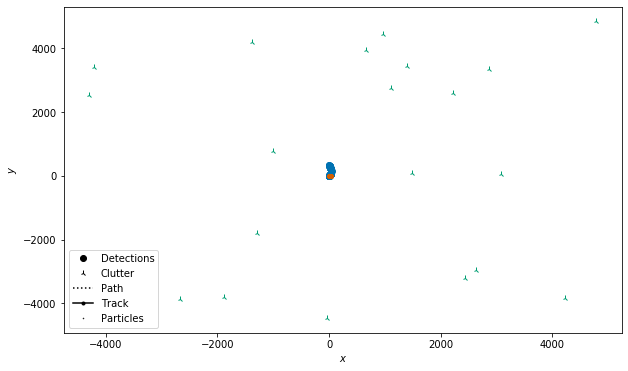

In [20]:
# METRICSGENERATOR 
from stonesoup.metricgenerator.plotter import TwoDPlotter
TwoDPlotter([0, 1], [0, 1], [0, 1]).plot_tracks_truth_detections(tracks, groundtruth_paths, detections)